# Exploratory Data Analysis and Data Preparation

This notebook explores the **HDF5-based** dataset (as described in the PDF) and prepares it for Vision Transformer (ViT) based segmentation.

## Contents
1. Setup and Imports
2. Data Loading and Inspection (HDF5)
3. Exploratory Data Analysis
4. Data Preprocessing (HDF5 -> Torch Dataset)
5. Data Preparation for ViT

In [1]:
%pip install --quiet imageio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import time

import h5py
import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from matplotlib.colors import ListedColormap
from src.config import get_dataset_path
from torch.utils.data import Dataset

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_context('notebook')

## 1. Setup and Configuration

We will open the HDF5 file using a config-based path retrieval (`get_dataset_path`). The PDF describes that images and masks reside within different internal groups, such as:

- `slices/camera_data/visible/0` (images captured after each layer is melted)
- `slices/camera_data/visible/1` (images captured after new powder is spread)
- `slices/segmentation_results/0..11` (binary masks for each anomaly class, per layer)

We can select which slice or segmentation data we want to examine (e.g. `0` for Powder, `1` for Printed, etc.).

In [3]:
path_file = get_dataset_path("tcr_phase1_build2")
if path_file is None:
    raise FileNotFoundError(
        "Dataset not found. Please check the configuration and data directory."
    )

print("Using HDF5 file:", path_file)

Using HDF5 file: /mnt/ssd/l-pbf-dataset/2021-04-16 TCR Phase 1 Build 2.hdf5


## 2. Data Loading and Inspection (HDF5)

We’ll open the HDF5 file and look at:
- Top-level metadata
- The shape and content of the slice images (`slices/camera_data/visible/0`)
- The shape and content of segmentation results (`slices/segmentation_results/0`, `1`, etc.)

In [4]:
with h5py.File(path_file, "r") as f:
    print("\nTop-level Attributes (Build Metadata):")
    for k, v in f.attrs.items():
        print(f"  {k} : {v}")

    # Example check: shapes of certain datasets
    slice_dset_name = "slices/camera_data/visible/0"  # post-melt images
    seg_dset_name   = "slices/segmentation_results/8" # spatter

    print("\nChecking if these datasets exist in the HDF5...")
    if slice_dset_name in f:
        ds_slice = f[slice_dset_name]
        print(f"{slice_dset_name} shape = {ds_slice.shape}")
    else:
        print(f"Dataset {slice_dset_name} NOT FOUND.")

    if seg_dset_name in f:
        ds_seg = f[seg_dset_name]
        print(f"{seg_dset_name} shape = {ds_seg.shape}")
    else:
        print(f"Dataset {seg_dset_name} NOT FOUND.")


Top-level Attributes (Build Metadata):
  core/build_name : TCR Phase 1 Build 2
  core/change_log : 
2021/04/21 09:05:32 v20.7.4: RABBAKAS [l03] instantiated the change log 
2021/04/21 09:05:32 v20.7.4: RABBAKAS [l03] created a new analysis file 
<> 2021/04/21 09:05:32: build name: TCR Phase 1 Build 2
<> 2021/04/21 09:05:32: build start date: 2021-04-16
<> 2021/04/21 09:05:32: using workspace: ConceptLaser M2 v3
<> 2021/04/21 09:05:32: using calibration file: ORNL1+20210414
<> 2021/04/21 09:05:32: using live configuration file: none
<> 2021/04/21 09:05:32: using stitching configuration file: none
<> 2021/04/21 09:05:32: dataset sensitivity marked as: False
<> 2021/04/21 09:05:32: loaded the workspace file created on: 2021-04-15_14-14-04
<> 2021/04/21 09:05:32: loaded the ORNL1+20210414 calibration file created on: 2021-04-14_17-21-42
<> 2021/04/21 09:05:33: loaded the DSCNN model created on: 2021-04-07_16-49-32
<> 2021/04/21 09:05:33: loaded the DSCNN-P model created on: 2021-04-08_11-

### Listing HDF5 Structure
If you want to see the entire group/dataset hierarchy, uncomment below to walk the file’s structure.

In [5]:
# with h5py.File(path_file, "r") as f:
#     def print_structure(name, obj):
#         print(name)
#     print("\n--- HDF5 Structure ---")
#     f.visititems(print_structure)

## 3. Exploratory Data Analysis

We’ll pick a few random layers from `slices/camera_data/visible/0` and compute basic stats.
Note that `ds_slice[layer]` is a 2D array (height, width).

In [6]:
def get_slice_stats(h5_file, dset_name, num_samples=5):
    """Compute mean/std/min/max for a few random layers."""
    if dset_name not in h5_file:
        print(f"Dataset '{dset_name}' not found!")
        return
    ds = h5_file[dset_name]
    num_layers = ds.shape[0]
    layer_indices = random.sample(range(num_layers), min(num_layers, num_samples))

    for layer_idx in layer_indices:
        arr = ds[layer_idx, ...]
        mean_val = arr.mean()
        std_val = arr.std()
        min_val = arr.min()
        max_val = arr.max()
        print(f"Layer {layer_idx}: mean={mean_val:.3f}, std={std_val:.3f}, min={min_val}, max={max_val}")  # noqa: E501

with h5py.File(path_file, "r") as f:
    print("\nSample stats from 'slices/camera_data/visible/0':")
    get_slice_stats(f, "slices/camera_data/visible/0", num_samples=3)


Sample stats from 'slices/camera_data/visible/0':
Layer 2026: mean=102.537, std=7.943, min=20.0, max=255.0
Layer 1545: mean=102.503, std=18.605, min=17.0, max=255.0
Layer 409: mean=103.196, std=33.016, min=12.0, max=255.0


We can also **visualize** a single layer’s slice image to see how it looks.

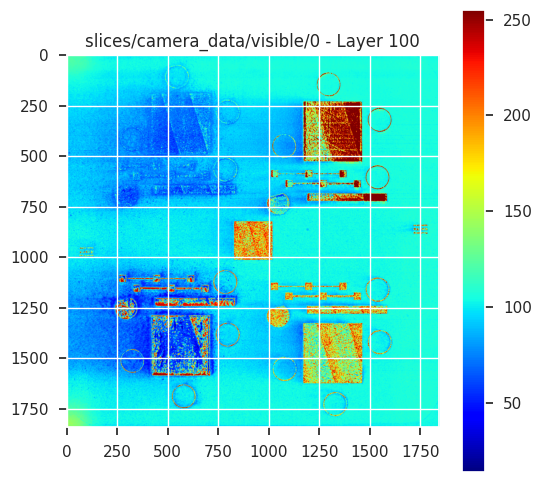

In [7]:
def plot_layer_image(h5_file, dset_name, layer_idx=600, cmap='gray'):
    if dset_name not in h5_file:
        print(f"Dataset '{dset_name}' not found!")
        return
    ds = h5_file[dset_name]
    if layer_idx < 0 or layer_idx >= ds.shape[0]:
        print(f"layer_idx {layer_idx} out of range!")
        return

    img_2d = ds[layer_idx, ...]
    plt.figure(figsize=(6,6))
    plt.imshow(img_2d, cmap=cmap)
    plt.title(f"{dset_name} - Layer {layer_idx}")
    plt.colorbar()
    plt.show()

with h5py.File(path_file, "r") as f:
    plot_layer_image(f, "slices/camera_data/visible/0", layer_idx=100, cmap='jet')

Which layers have the desired anomalies?

In [8]:
from src.utils.extract_examples import collect_example_multiview, collect_example_pairs

# Single-view, melt camera
pairs = collect_example_pairs(path_file, max_per_class=3)

# Multi-view (melt + recoater) for Recoater Streaking only
mv_pairs = collect_example_multiview(
    path_file,
    camera_datasets=[
        "slices/camera_data/visible/0",
        "slices/camera_data/visible/1",
    ],
    class_ids=None,
    max_per_class=2,
)

In [9]:
# Single-view (melt) with 8 threads → progress bar appears
pairs = collect_example_pairs(
    path_file,
    max_per_class=3,
    n_workers=8          # ← add this
)

Scanning masks:   0%|          | 0/12 [00:00<?, ?it/s]

In [10]:
# Multi-view (melt + recoater) for class-4 with a bar
mv_pairs = collect_example_multiview(
    path_file,
    camera_datasets=[
        "slices/camera_data/visible/0",
        "slices/camera_data/visible/1",
    ],
    class_ids=None,
    max_per_class=2,
    n_workers=8          # ← and here
)

In [11]:
ex = mv_pairs[7][0]
print(ex.layer)                     # layer index
print(ex.imgs.keys())               # both camera paths
img0 = ex.imgs["slices/camera_data/visible/0"]
img1 = ex.imgs["slices/camera_data/visible/1"]
mask = ex.mask                      # Boolean mask for class 4


5
dict_keys(['slices/camera_data/visible/0', 'slices/camera_data/visible/1'])


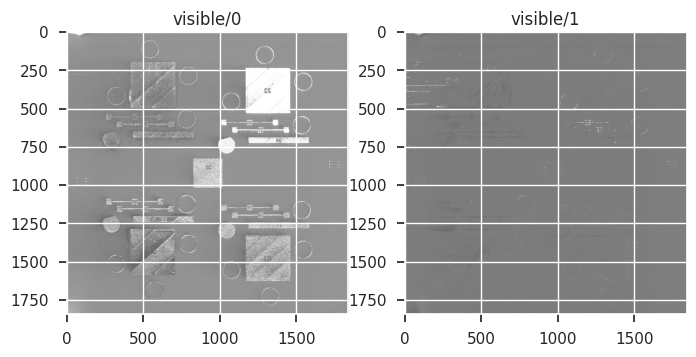

In [12]:
plt.subplot(1,2,1); plt.imshow(img0, cmap="gray"); plt.imshow(mask, alpha=0.35); plt.title("visible/0")
plt.subplot(1,2,2); plt.imshow(img1, cmap="gray"); plt.imshow(mask, alpha=0.35); plt.title("visible/1")
plt.show()

(np.float64(-0.5), np.float64(1841.5), np.float64(1841.5), np.float64(-0.5))

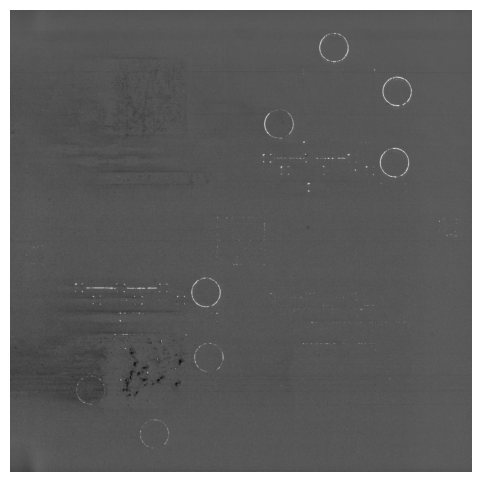

In [44]:
cmap_streak = ListedColormap([(0, 0, 0, 0), 
                              (1, 0, 0, 0.9)]) 


cmap_spatter = ListedColormap([(0, 0, 0, 0), 
                               (0, 0, 1, 0.7)])

layer = 350
with h5py.File(path_file, "r") as f:
    img  = f["slices/camera_data/visible/1"][layer]
    m3   = f["slices/segmentation_results/7"][layer]  # streak
    # m8   = f["slices/segmentation_results/8"][layer]  # spatter

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.imshow(m3, cmap=cmap_streak)
# plt.imshow(m8, cmap=cmap_spatter)
plt.axis("off")

YOLO data visualizatiion

/tmp/ipykernel_838/3784260618.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img  = imageio.imread("../data/legacy/tcr_phase1_build2/images/train/00060.png")
/tmp/ipykernel_838/3784260618.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread("../data/legacy/tcr_phase1_build2/labels/train/00060.png")


(np.float64(-0.5), np.float64(1841.5), np.float64(1841.5), np.float64(-0.5))

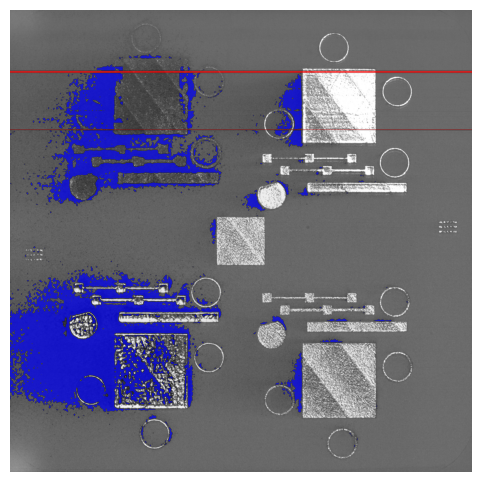

In [14]:
# load
img  = imageio.imread("../data/legacy/tcr_phase1_build2/images/train/00060.png")
mask = imageio.imread("../data/legacy/tcr_phase1_build2/labels/train/00060.png")

# define semi-transparent colormaps
cmap_spatter = ListedColormap([(0,0,0,0), (0,0,1,0.7)])  # blue
cmap_streak  = ListedColormap([(0,0,0,0), (1,0,0,0.7)])  # red

# build boolean masks
m_sp = mask==1
m_st = mask==2

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.imshow(m_sp, cmap=cmap_spatter)
plt.imshow(m_st, cmap=cmap_streak)
plt.axis("off")

Counting the number of pixels for an anomaly, to test how fast it could be determined.

In [15]:
with h5py.File(path_file, "r") as f:
    layer_idx = 200
    spatter_mask = f["slices/segmentation_results/8"][layer_idx]
    start = time.perf_counter()
    spatter_pixel_count = np.count_nonzero(spatter_mask)
    elapsed = time.perf_counter() - start
    print(
        f"Number of spatter anomaly pixels in layer {layer_idx}: "
        f"{spatter_pixel_count}"
    )
    print(f"Time taken: {elapsed*1e3:.3f} ms")

Number of spatter anomaly pixels in layer 200: 444934
Time taken: 0.935 ms


Other datasets

SI383820211201123521_00058_20211201T135234.807000.jpg

SI383820211201123521_00058_20211201T135234.807000.jpg

In [16]:
import pathlib
from collections.abc import Iterable, Sequence

import cv2
import matplotlib.pyplot as plt
from matplotlib import colormaps

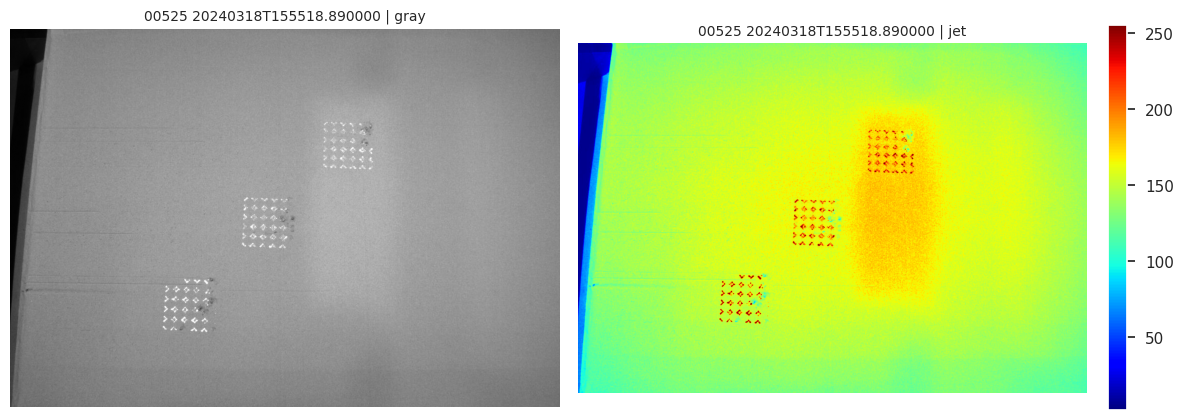

In [17]:
def _short_title(path: pathlib.Path, keep_parts: int = 2) -> str:
    """Return a concise identifier from a filename."""

    tokens: Sequence[str] = path.stem.split("_")
    tokens = tokens[-keep_parts:] if keep_parts else tokens
    return " ".join(tokens)


def colourise_images(
    img_paths: Iterable[str | pathlib.Path],
    cmap: str = "jet",
    vmin: int | None = None,
    vmax: int | None = None,
    figsize: tuple[int, int] = (6, 6),
    keep_parts: int = 2,            # <-- how many trailing tokens to keep
) -> None:
    """Display one or more grayscale images with a pseudocolour overlay."""

    cmap_obj = colormaps[cmap]

    for fname in map(pathlib.Path, img_paths):
        img = cv2.imread(str(fname), cv2.IMREAD_UNCHANGED)
        if img is None:
            print(f"⚠️  Could not read {fname}")
            continue

        # Convert to grayscale if necessary (handles RGB or BGR)
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        short = _short_title(fname, keep_parts)

        fig, axes = plt.subplots(
            1, 2,
            figsize=(figsize[0] * 2, figsize[1]),
            sharex=True, sharey=True
        )

        # Original grayscale
        axes[0].imshow(img, cmap="gray", vmin=vmin, vmax=vmax)
        axes[0].set_title(f"{short} | gray", fontsize=10)
        axes[0].axis("off")

        # Pseudo-colour version
        pcm = axes[1].imshow(img, cmap=cmap_obj, vmin=vmin, vmax=vmax)
        axes[1].set_title(f"{short} | {cmap}", fontsize=10)
        axes[1].axis("off")

        fig.colorbar(pcm, ax=axes[1], fraction=0.035, pad=0.04)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    root = pathlib.Path(
        "../data/14996806/Preprocessed Data/Preprocessed Data for Object Detection/PB_images"
    )
    images = [
        root / "SI383820240318120348_00525_20240318T155518.890000.jpg",
    ]
    colourise_images(images, cmap="jet")


## 4. Data Preprocessing (HDF5 -> Torch Dataset)

Instead of reading PNG files, we define a custom PyTorch `Dataset` that reads directly from the HDF5 file. For each index (which corresponds to a layer), we retrieve:
- An image from `camera_data/visible/0` (for instance)
- A segmentation mask from `slices/segmentation_results/1` (if desired)

Because we have **one HDF5 file** containing many layers, we can open it once in the dataset’s constructor, or pass a path and open lazily. The example below keeps it open, so we must ensure it is closed properly. Alternatively, you can open it in `__getitem__` each time, but that’s slower.

> **Note**: If you want multiple segmentation classes, you might read multiple `slices/segmentation_results/#` arrays, or combine them. Below we just load a single mask dataset for demonstration.

In [18]:
class HDF5MetalDataset(Dataset):
    """Custom dataset reading from HDF5 for images and masks."""

    def __init__(
        self,
        hdf5_path,
        image_dset="slices/camera_data/visible/0",
        mask_dset=None,
        transform=None
    ):
        super().__init__()
        self.hdf5_path = hdf5_path
        self.image_dset_name = image_dset
        self.mask_dset_name = mask_dset
        self.transform = transform

        self.h5_file = h5py.File(
            hdf5_path, 'r'
        )

        if self.image_dset_name not in self.h5_file:
            raise ValueError(f"Image dataset '{self.image_dset_name}' not found in HDF5.")  # noqa: E501
        self.img_ds = self.h5_file[self.image_dset_name]
        self.num_layers = self.img_ds.shape[0]

        if self.mask_dset_name:
            if self.mask_dset_name not in self.h5_file:
                raise ValueError(f"Mask dataset '{self.mask_dset_name}' not found in HDF5.")  # noqa: E501
            self.mask_ds = self.h5_file[self.mask_dset_name]
            if self.mask_ds.shape[0] != self.num_layers:
                raise ValueError("Image and mask dataset layer counts do not match!")
        else:
            self.mask_ds = None

    def __len__(self):
        return self.num_layers

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.num_layers:
            raise IndexError("Layer index out of range.")

        img_2d = self.img_ds[idx, ...].astype(np.float32)
        img_3ch = np.stack([img_2d, img_2d, img_2d], axis=0)  # shape (3, H, W)

        mask_2d = None
        if self.mask_ds is not None:
            mask_2d = self.mask_ds[idx, ...].astype(np.uint8)

        if self.transform:
            # Convert to a Range [0,1], etc., or do standard transforms
            # We'll do the final transform outside of __getitem__ for clarity.
            pass

        img_tensor = torch.from_numpy(img_3ch)  # shape: (3, H, W)
        mask_tensor = None
        if mask_2d is not None:
            mask_tensor = torch.from_numpy(mask_2d)  # shape: (H, W)

        return {
            'image': img_tensor,
            'mask': mask_tensor,
            'layer_index': idx
        }

    def close(self):
        """Close the HDF5 file when done."""
        self.h5_file.close()


## 5. Data Preparation for YOLO

This process takes about 3 hours. 

In [19]:
# !python ../src/utils/export_to_yolo_data.py \
#         tcr_phase1_build2 \
#         --val_split 0.15 \
#         --workers 6